In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import igl
import numpy as np
import scipy as sp
from meshplot import plot, subplot, interact
from scipy.sparse.linalg import spsolve
import meshplot
import os
import math
import meshzoo

In [2]:
def normalVector(phi, theta):
    x = math.sin(phi) * math.cos(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(phi)
    norm = [x,y,z]
    return norm

def dotProduct(vec1, vec2):
    a = 0
    for i in range(len(vec1)):
        a += vec1[i]*vec2[i]
    return a

def angle(norm, vector, givAng):
    a = dotProduct(norm,vector)
    len1 = math.sqrt(dotProduct(norm, norm))
    len2 = math.sqrt(dotProduct(vector, vector))
    b = a/(len1*len2)
    if b>1:
        b = 1
    elif b<-1:
        b = -1
    else:
        ang = math.acos(b)
    return ang<=givAng


norm1 = normalVector(math.pi/2, 2*math.pi/3)
norm2 = normalVector(math.pi/2, -2*math.pi/3)
norm3 = normalVector(math.pi/2, 0)

In [3]:
def shapeGen(R, A):
    points, cells = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=30, radius=R)

    v = points

    f1_id = []
    f2_id = []

    color = []


    for i in range(len(v)):
        if angle(norm1, v[i], A) or angle(norm3, v[i], A):
            color += [2]
            f1_id += [i]
        else:
            if angle(norm2, v[i], A) :
                color += [-2]
                f2_id += [i]
            else:
                color += [0]
    return [v,f1_id,f2_id,points,cells,color]


2238


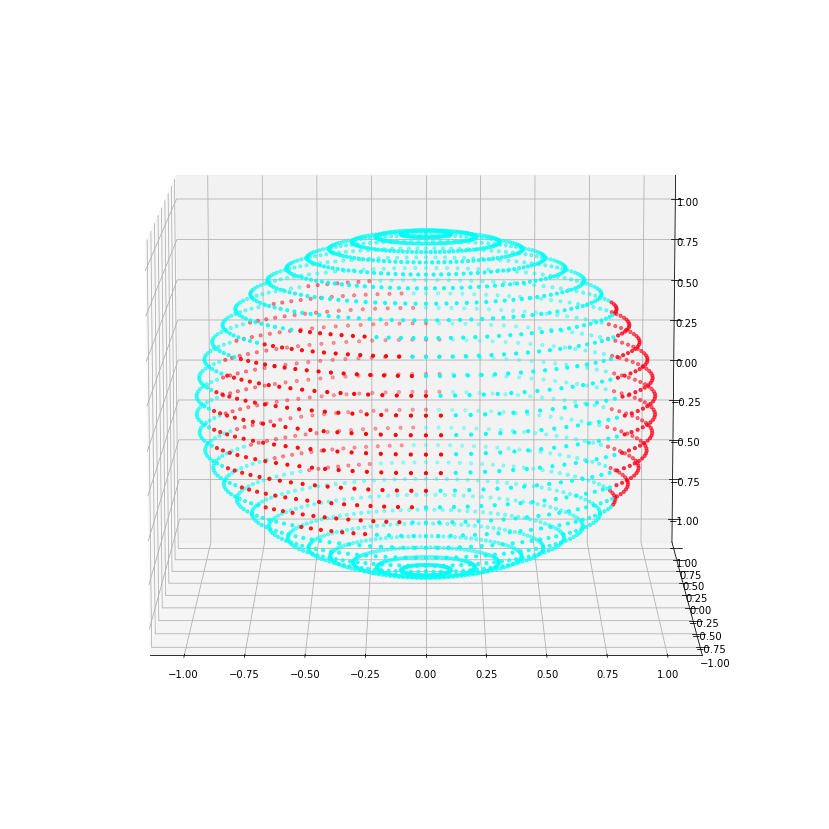

In [4]:
def show(R,A):
    v, f1_id, f2_id, points, cells, color = shapeGen(R,A)
    p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s = 10 , c=color, cmap='hsv'); #, cmap='hsv' )

    ax.view_init(10,-90)
    freePoint = len(v)-len(f1_id)-len(f2_id)
    print(freePoint)
    plt.show()
show(1,math.pi/5)

In [5]:
def miniQ(l,v,f1,f2):
    lt = np.transpose(l)
    boundV = []
    boundLt = []
    nonBoundLt = []
    nonBoundL2 = []
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            boundV.append(v[i])
            boundLt.append(lt[i])
        else:
            nonBoundLt.append(lt[i])

    boundL = np.transpose(boundLt)
    nonBoundL = np.transpose(nonBoundLt)

    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            nonBoundL2.append(nonBoundL[i])
    b = -boundL.dot(boundV)
    b2 = []
    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            b2.append(b[i])
    x = spsolve(nonBoundL2, b2)
    final = []
    temp = 0
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            final.append(v[i])
        else:
            final.append(x[temp])
            temp+=1
    return np.asarray(final)

In [6]:
def minimization(R,A):
    v = shapeGen(R,A)[0]
    cells = shapeGen(R,A)[4]
    f1_id = shapeGen(R,A)[1]
    f2_id = shapeGen(R,A)[2]

    vs = [v]
    es = []

    l = -1/8*igl.cotmatrix(vs[0],cells)
    vt = np.transpose(vs[0])
    es.append(vt.dot(l.dot(vs[0])).trace())

    for i in range(100):
        l = -1/8*igl.cotmatrix(vs[i],cells).toarray()

        Q = miniQ(l,vs[i],f1_id,f2_id)
        vs.append(Q)

        # energy 
        vt = np.transpose(vs[i+1])
        if(math.isnan(vt.dot(l.dot(vs[i+1])).trace())): break
        es.append(vt.dot(l.dot(vs[i+1])).trace())
    es=[ i for i in es if not(math.isnan(i)==True)]
    return [vs, cells, es]

In [31]:
def area1(angle):
    return 4*math.pi * (math.sin(angle))**2



x = [math.pi/4.5,math.pi/4.4,math.pi/4.3,math.pi/4.2,math.pi/4.1, math.pi/4]

convV = []
convC = []
R = 1
for i in x:
    vs,cells,es = minimization(R,i)
    es=[ i for i in es if not(math.isnan(i)==True)]
    lastidx = len(es)-1
    convV.append(vs[lastidx])
    convC.append(cells)



c:\Users\User\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\User\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [33]:
import sys

convA = []
def area2(radius):
    return 4/3*math.pi*(radius)**3

R = []
for item in convV:
    radius = sys.maxsize
    for i in item:
        temp = math.sqrt(i[0]**2+i[1]**2+i[2]**2)
        if(radius>temp):
            radius = temp
    R.append(radius)

for i in range(len(R)):
    convA.append(R[i])
    

[0.19572549024422378, 0.29389098972283345, 0.28799022290779475, 0.42875357497512995, 0.4611592686943832, 0.49478160228286416]


Text(0.5, 1.0, 'sphere')

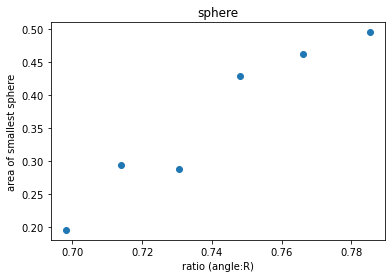

In [36]:
print(R)

plt.scatter(x,convA)
plt.ylabel("area of smallest sphere")
plt.xlabel("ratio (angle:R)")
plt.title("sphere")

In [35]:
p = subplot(convV[0], convC[0], shading={"wireframe": False}, s=[1,4,0])
p = subplot(convV[1], convC[1], shading={"wireframe": False}, s=[1,4,1],data=p)
p = subplot(convV[2], convC[2], shading={"wireframe": False}, s=[1,4,2],data=p)
p = subplot(convV[3], convC[3], shading={"wireframe": False}, s=[1,4,3],data=p)
p = subplot(convV[3], convC[4], shading={"wireframe": False}, s=[2,4,1],data=p)




In [28]:

items = [[1,2,3],[2,4,5],[10,12,33]]
A = []
radius = sys.maxsize
for item in items:
    radius = sys.maxsize
    for i in item:
        temp = math.sqrt(i**2+i**2+i**2)
        if(radius>temp):
            radius = temp
    A.append(radius)
A


[1.7320508075688772, 3.4641016151377544, 17.320508075688775]